In [1]:
import os
os.environ['THEANO_FLAGS']='device=cpu'
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Producing a simulated dataset

### Define number of sites, observations and covariates

In [22]:
n_locations = 20
n_timesteps = 100
p_static    = 3
p_dynamic   = 4
error_sd    = 1.5
error_corr  = 0.3

### Randomly sampled simulated covariates and coefficients

In [23]:
covariates_static  = np.random.randn(n_locations,p_static)
covariates_dynamic = np.random.randn(n_locations,n_timesteps,p_dynamic)

coef_static  = np.random.randn(p_static)
coef_dynamic = np.random.randn(p_dynamic)

intercept = np.random.randn()

In [24]:
print('True static coefficients:',coef_static)
print('True dynamic coefficients:',coef_dynamic)
print('True intercept:',intercept)

True static coefficients: [-0.44477925 -0.26928313 -0.67750226]
True dynamic coefficients: [-0.6360322   0.863061   -0.47180954  1.40720253]
True intercept: 1.2969126670128792


### Create AR(1) error process

In [25]:
error_jumps = np.random.randn(n_locations,n_timesteps)

errors = np.zeros([n_locations,n_timesteps])
for i in range(1,n_timesteps):
    errors[:,i] = errors[:,i-1]*error_corr + error_jumps[:,i]

### Combine error with predictors and coefficients

In [6]:
mu       = covariates_static.dot(coef_static)[:,np.newaxis] + covariates_dynamic.dot(coef_dynamic) + intercept
response = mu + errors
print(response.shape)

(20, 100)


# Fitting a basic linear regression with no dynamic covariates

### Defining the model in PyMC3

In [26]:
with pm.Model() as basic_model:
    beta    = pm.Normal('beta',shape=[p_static,1])
    alpha   = pm.Normal('alpha')
    mu      = pm.math.dot(covariates_static,beta) + alpha
    err_var = pm.InverseGamma('err_var',0.1,0.1)
    err_sd  = pm.Deterministic('err_sd',err_var**0.5)
    y = pm.Normal('y',mu=mu,sd=err_sd,observed=response)
    trace1 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [err_var, alpha, beta]
Sampling 2 chains: 100%|██████████| 2000/2000 [00:02<00:00, 707.38draws/s] 


### Examining the posterior samples

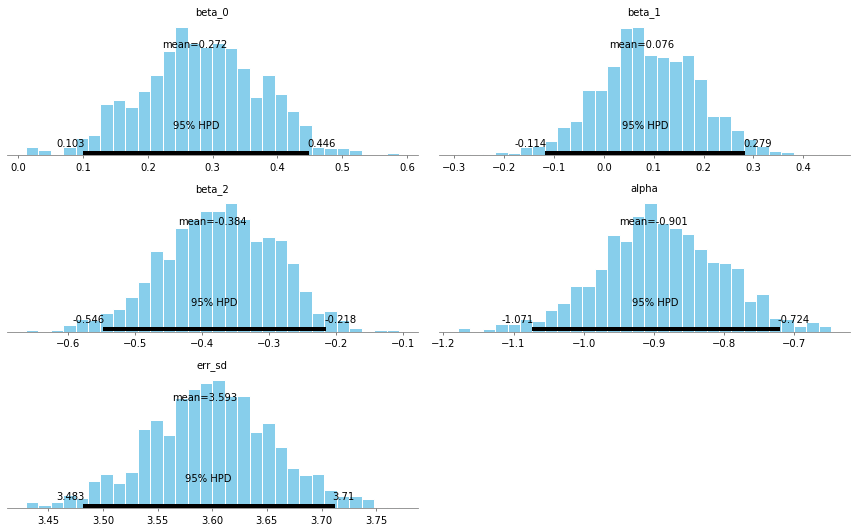

In [27]:
pm.plot_posterior(trace1,varnames=['beta','alpha','err_sd']);

# Imputing missing responses

In [9]:
mask = np.random.randn(*response.shape) > 0
masked_responses = np.ma.masked_array(data=response,mask=mask)


In [10]:
with pm.Model() as impute_model:
    beta    = pm.Normal('beta',shape=[p_static,1])
    alpha   = pm.Normal('alpha')
    mu      = pm.math.dot(covariates_static,beta) + alpha
    err_var = pm.InverseGamma('err_var',0.1,0.1)
    err_sd  = pm.Deterministic('err_sd',err_var**0.5)
    y = pm.Normal('y',mu=mu,sd=err_sd,observed=masked_responses)
    trace2 = pm.sample()

/home/ckrapu/anaconda3/envs/pymc3/lib/python3.6/site-packages/pymc3/model.py:1266: UserWarning: Data in y contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, UserWarning)
/home/ckrapu/anaconda3/envs/pymc3/lib/python3.6/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/home/ckrapu/anaconda3/envs/pymc3/lib/python3.6/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a 

In [11]:
trace2['y_missing'].shape

(1000, 1020)

# Fitting a regression on time-varying covariates

In [12]:
with pm.Model() as dynamic_covariate_model:
    beta         = pm.Normal('beta',shape=[p_static,1])
    alpha        = pm.Normal('alpha')
    beta_dynamic = pm.Normal('beta_dynamic',shape=[p_dynamic])
    mu      = pm.math.dot(covariates_static,beta) + pm.math.dot(covariates_dynamic,beta_dynamic) + alpha
    err_var = pm.InverseGamma('err_var',0.1,0.1)
    err_sd  = pm.Deterministic('err_sd',err_var**0.5)
    y = pm.Normal('y',mu=mu,sd=err_sd,observed=response)
    trace3 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [err_var, beta_dynamic, alpha, beta]
Sampling 2 chains: 100%|██████████| 2000/2000 [00:16<00:00, 121.68draws/s]


/home/ckrapu/anaconda3/envs/pymc3/lib/python3.6/site-packages/pymc3/plots/forestplot.py:318: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
  ticks.tick1On = False
/home/ckrapu/anaconda3/envs/pymc3/lib/python3.6/site-packages/pymc3/plots/forestplot.py:319: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
  ticks.tick2On = False


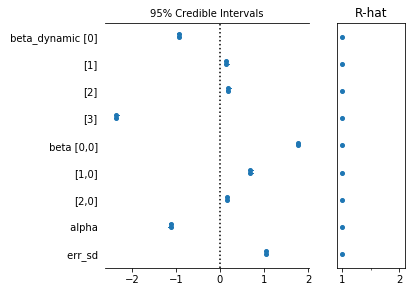

In [13]:
pm.forestplot(trace3,varnames=['beta_dynamic','beta','alpha','err_sd']);

# Including an AR(1) error

In [14]:
with pm.Model() as correlated_error_model:
    beta         = pm.Normal('beta',shape=[p_static,1])
    alpha        = pm.Normal('alpha')
    beta_dynamic = pm.Normal('beta_dynamic',shape=[p_dynamic])
    mu           = pm.math.dot(covariates_static,beta) +pm.math.dot(covariates_dynamic,beta_dynamic) + alpha
    
    tau      = pm.Gamma('tau',0.1,0.1)
    k        = pm.Uniform('k')
    error    = pm.AR1('error', k=k, tau_e=tau, observed=(response-mu).T)
    
    trace4 = pm.sample(tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [k, tau, beta_dynamic, alpha, beta]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:28<00:00, 105.47draws/s]


/home/ckrapu/anaconda3/envs/pymc3/lib/python3.6/site-packages/pymc3/plots/forestplot.py:318: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
  ticks.tick1On = False
/home/ckrapu/anaconda3/envs/pymc3/lib/python3.6/site-packages/pymc3/plots/forestplot.py:319: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
  ticks.tick2On = False


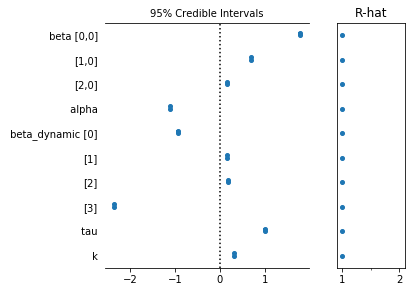

In [15]:
pm.forestplot(trace4);

In [19]:
print('Posterior mean estimate of static coefficients:',trace4['beta'].mean(axis=0)[:,0])
print('True value of static coefficients:',coef_static)

Posterior mean estimate of static coefficients: [1.7775455  0.6946681  0.16773374]
True value of static coefficients: [1.76223208 0.71588468 0.19443324]


In [20]:
print('Posterior mean estimate of dynamic coefficients:',trace4['beta_dynamic'].mean(axis=0))
print('True value of dynamic coefficients:',coef_dynamic)

Posterior mean estimate of dynamic coefficients: [-0.94458723  0.16023508  0.1901266  -2.3547285 ]
True value of dynamic coefficients: [-0.96610595  0.14703013  0.17970976 -2.34250193]


In [21]:
print('Posterior mean estimate of AR1 autocorrelation:',trace4['k'].mean())
print('True value of AR1 autocorrelation:',error_corr)

Posterior mean estimate of AR1 autocorrelation: 0.30739155
True value of AR1 autocorrelation: 0.3


# Debugging a model

### Misspecified variable shapes

In [29]:
with pm.Model() as bad_model:
    beta    = pm.Normal('beta',shape=[p_static,1])
    alpha   = pm.Normal('alpha')
    mu      = pm.math.dot(covariates_static,beta) + alpha
    err_var = pm.InverseGamma('err_var',0.1,0.1)
    err_sd  = pm.Deterministic('err_sd',err_var**0.5)
    y = pm.Normal('y',mu=mu,sd=err_sd,observed=response)
    trace4 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [err_var, alpha, beta]
Sampling 2 chains: 100%|██████████| 2000/2000 [00:03<00:00, 633.95draws/s] 


### Bad initial energy

In [30]:
with pm.Model() as bad_model:
    beta    = pm.Normal('beta',shape=[p_static,1])
    alpha   = pm.Normal('alpha')
    mu      = pm.math.dot(covariates_static,beta) + alpha
    err_var = pm.InverseGamma('err_var',0.1,0.1)
    err_sd  = pm.Deterministic('err_sd',err_var**0.5)
    y = pm.Normal('y',mu=mu,sd=-err_sd,observed=response)
    trace4 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [err_var, alpha, beta]
Sampling 2 chains:   0%|          | 0/2000 [00:00<?, ?draws/s]/home/ckrapu/anaconda3/envs/pymc3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ckrapu/anaconda3/envs/pymc3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)

Bad initial energy, check any log probabilities that are inf or -inf, nan or very small:
y   -inf


ParallelSamplingError: Bad initial energy

In [31]:
for variable in bad_model.basic_RVs:
    print(variable.name, variable.logp(bad_model.test_point))

beta -2.7568157
alpha -0.9189385
err_var_log__ -3.3431816
y -inf


In [34]:
mu

Elemwise{add,no_inplace}.0

### Missing input error

In [35]:
with pm.Model() as bad_model:
    beta    = pm.Normal('beta',shape=[p_static,1])
    alpha   = pm.Normal('alpha')
    mu      = pm.math.dot(covariates_static,beta) + alpha
    err_var = pm.InverseGamma('err_var',0.1,0.1)
    err_sd  = pm.Deterministic('err_sd',err_var**0.5)
    y = pm.Normal('y', mu=mu, sd=-err_sd,observed=response)
    trace4 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [err_var, alpha, beta]
Sampling 2 chains:   0%|          | 0/2000 [00:00<?, ?draws/s]/home/ckrapu/anaconda3/envs/pymc3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ckrapu/anaconda3/envs/pymc3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)

Bad initial energy, check any log probabilities that are inf or -inf, nan or very small:
y   -inf


ParallelSamplingError: Bad initial energy